In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random

from scipy.integrate import quad
import time

# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma, d_sigma_sm
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
quarks = [
    (2, 2/3*e, 'u', 1/2),
     (1, -1/3*e, 'd', -1/2),
     (3, -1/3*e, 's', -1/2),
     (4, 2/3*e, 'c', 1/2),
      (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2019, -0.0467, 0.4533), (1, -0.1009, 0.0233, -0.4767), (3, -0.1009, 0.0233, -0.4767), (4, 0.2019, -0.0467, 0.4533), (5, -0.1009, 0.0233, -0.4767)]


In [3]:
#Don't foregt the metric convenction (+, -, -, -)
g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
CL1 = tn.tensor([
    [0, 0, 0, 0],
    [0, 1e-5, 0, 0],
    [0, 0, -1e-5, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL2 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, -1e-5, 0],
    [0, -1e-5, 0, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL3 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, -1e-5],
    [0, 0, 0, 0],
    [0,-1e-5, 0, 0]
], dtype=tn.float32)
CL4 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, -1e-5],
    [0,0,-1e-5, 0]
], dtype=tn.float32)


CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

# C0 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ], dtype=tn.float32)

In [4]:
# Define the constant tensors once
A = 1 / np.sqrt(2)
p1 = A * tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 = A * tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2018, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=0.25).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    
    R_mat = tn.matmul(R_y_lat, tn.matmul(R_x_azi, tn.matmul(R_z, R_Z_omega)))
    R_matrix1 = tn.einsum('am,na->mn', g, R_mat)
    R_matrix2 = tn.einsum('ma,an->mn', g, R_mat)

    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)

    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

In [5]:
# Generate a list random of Q values 
Q_values = []
for _ in range(len(contrelep1)):
    while True:
        Q = np.random.normal(loc=75, scale=2)
        if 70 <= Q <= 80:
            Q_values.append(Q)
            break

In [6]:
results = []
for (pm, pn), Q in zip(zip(contrelep1, contrelep2), Q_values):
    
    # Calculate Q^2
    Q2 = Q**2
    
    # Perform all calculations with the same Q for this iteration
    result_sm = d_sigma_sm(Q2, quark_couplings)
    result_sme1 = d_sigma(Q2, CL1, CR, pm, pn, quark_couplings)
    result_sme2 = d_sigma(Q2, CL2, CR, pm, pn, quark_couplings)
    result_sme3 = d_sigma(Q2, CL3, CR, pm, pn, quark_couplings)
    result_sme4 = d_sigma(Q2, CL4, CR, pm, pn, quark_couplings)
    
    # Store the results
    results.append({
        'Q': Q,
        'result_sm': result_sm,
        'result_sme1': result_sme1,
        'result_sme2': result_sme2,
        'result_sme3': result_sme3,
        'result_sme4': result_sme4
    })

# Function to convert timestamps to hours
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:105: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand1, tau, 1)
/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the int

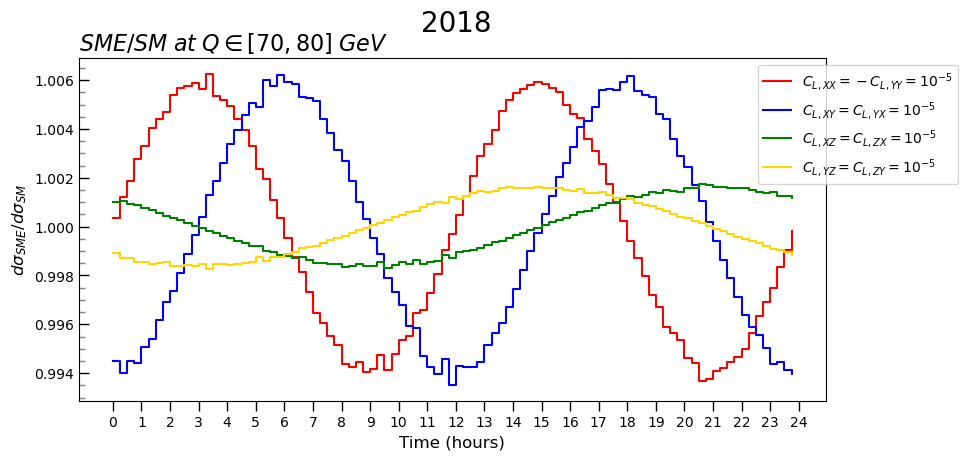

In [7]:
dratio1l = [result['result_sme1'] / result['result_sm'] for result in results]
dratio2l = [result['result_sme2'] / result['result_sm'] for result in results]
dratio3l = [result['result_sme3'] / result['result_sm'] for result in results]
dratio4l = [result['result_sme4'] / result['result_sm'] for result in results]

dratio1 = np.array(dratio1l)
dratio2 = np.array(dratio2l)
dratio3 = np.array(dratio3l)
dratio4 = np.array(dratio4l)
hours_array = np.array(hours_start)

plt.figure(figsize=(12, 6))

# Plot data
plt.step(hours_array, dratio1, where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 10^{-5}$', linewidth=1.5)
plt.step(hours_array, dratio2, where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 10^{-5}$', linewidth=1.5)
plt.step(hours_array, dratio3, where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 10^{-5}$', linewidth=1.5)
plt.step(hours_array, dratio4, where='post', color='gold', label='$C_{L,YZ} = C_{L,ZY} = 10^{-5}$', linewidth=1.5)

# Customizing the legend
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1), fontsize=10, frameon=True)

# Adding labels and title 
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('$d\\sigma_{SME}/d\\sigma_{SM}$', fontsize=12)
plt.title('$SME/SM \; at \; Q \in [70,80] \;GeV$', fontsize=16, loc='left')
plt.text(12, 1.008, '2018', fontsize=20, horizontalalignment='center')

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)  
plt.tick_params(which='both', width=1)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='gray')
plt.tick_params(axis='y', direction='in', which ='both') 

plt.xticks(ticks=range(0, 25, 1), labels=[str(hour) for hour in range(0, 25, 1)])

plt.tight_layout(rect=[0, 0, 0.8, 0.8]) 

# Showing the plot
plt.savefig("liv.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

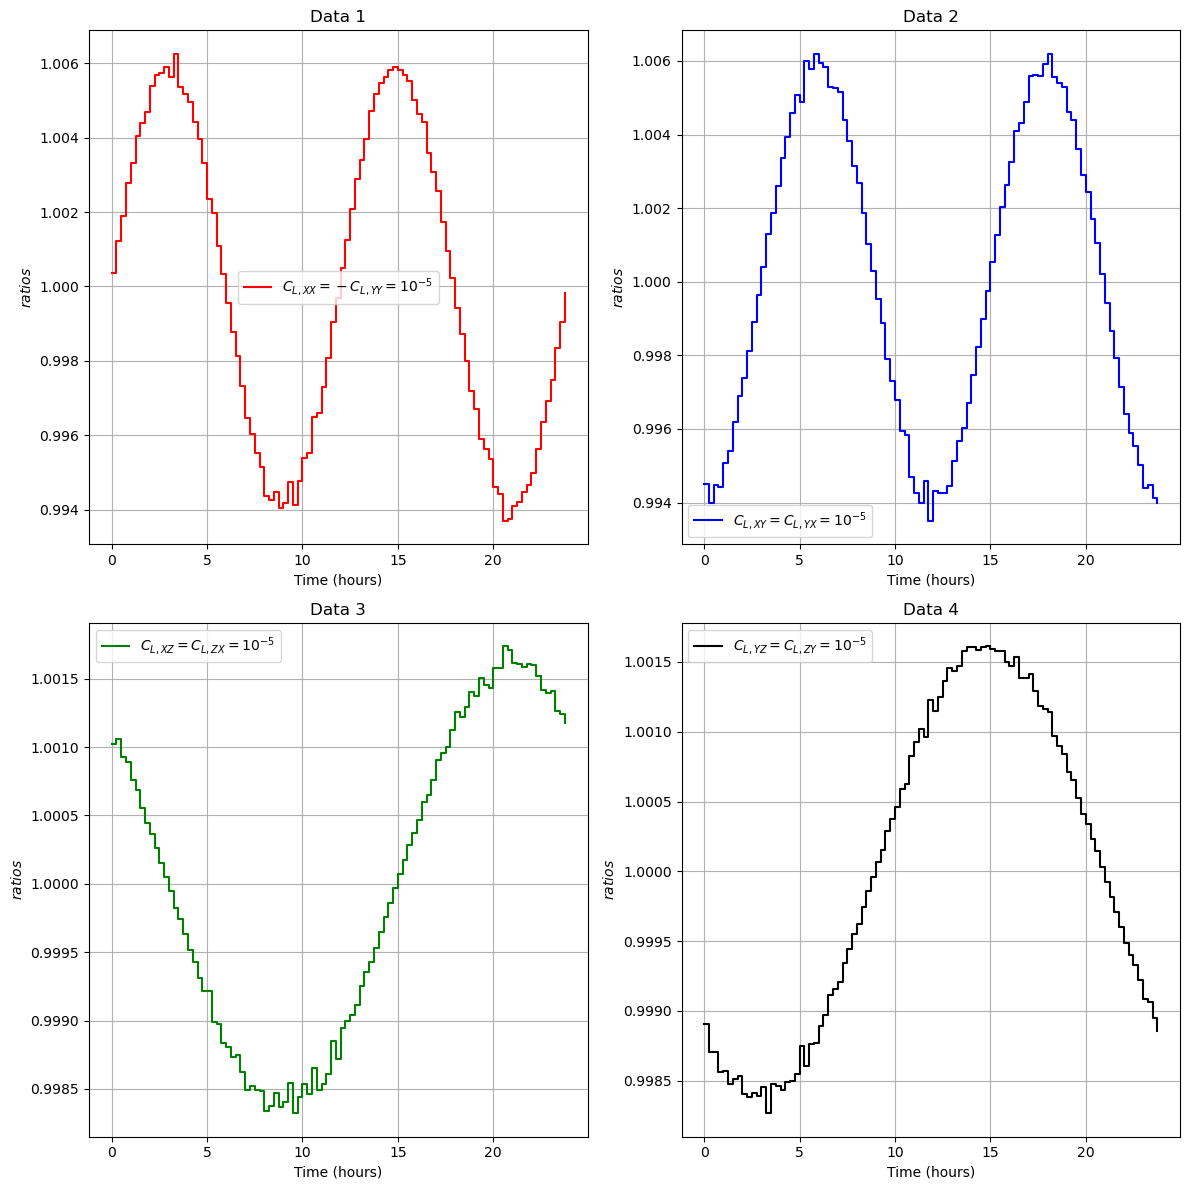

In [8]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot data in each subplot
axs[0, 0].step(hours_array, dratio1, where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 10^{-5}$')
axs[0, 0].set_title('Data 1')
axs[0, 0].set_xlabel('Time (hours)')
axs[0, 0].set_ylabel('$ratios$')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].step(hours_array, dratio2, where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 10^{-5}$')
axs[0, 1].set_title('Data 2')
axs[0, 1].set_xlabel('Time (hours)')
axs[0, 1].set_ylabel('$ratios$')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].step(hours_array, dratio3, where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 10^{-5}$')
axs[1, 0].set_title('Data 3')
axs[1, 0].set_xlabel('Time (hours)')
axs[1, 0].set_ylabel('$ratios$')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].step(hours_array, dratio4, where='post', color='black', label='$C_{L,YZ} = C_{L,ZY} = 10^{-5}$')
axs[1, 1].set_title('Data 4')
axs[1, 1].set_xlabel('Time (hours)')
axs[1, 1].set_ylabel('$ratios$')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:105: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand1, tau, 1)


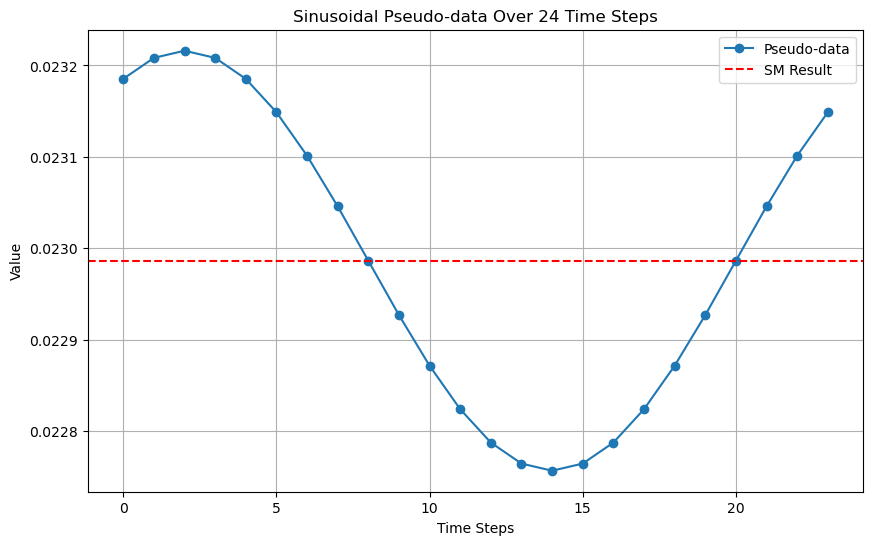

In [9]:
resultssm = [d_sigma_sm(75**2,quark_couplings)]
# Assume resultssm is a list with the result from the SM calculation

# Generate sinusoidal pseudo-data over 24 time steps with a 0.01 deviation
time_steps = np.arange(24)
amplitude = 0.01 * resultssm[0]  # 1% of the SM result as the amplitude of the sinusoid
np.random.seed(42)  # For reproducibility
pseudo_data = resultssm[0] + amplitude * np.sin(2 * np.pi * time_steps / 24+np.pi*8/24) 

# Plot the pseudo-data
plt.figure(figsize=(10, 6))
plt.plot(time_steps, pseudo_data, marker='o', linestyle='-', label='Pseudo-data')
plt.axhline(y=resultssm[0], color='r', linestyle='--', label='SM Result')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Sinusoidal Pseudo-data Over 24 Time Steps')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Create the linear values
linear_values = tn.linspace(-0.025, 0.025, steps=20)

# Initialize an empty list to hold the tensors
C_values = []

# Loop through the linear values and create the tensors
for value in linear_values:
    tensor = tn.zeros((4,4))  # Create a tensor of the specified size, filled with zeros
    tensor[(2,3)] = value  # Set the value at the first index
    tensor[(3,2)] = value  # Set the value at the second index
    C_values.append(tensor)  # Append the tensor to the list


In [11]:

# Calculate d_sigma for each value of C
def calculate_d_sigma(C, Q2, pm, pn, quark_couplings):
    return d_sigma(Q2, C, CR, pm, pn, quark_couplings)

# Compute d_sigma for all pm, pn pairs across different C values
d_sigma_results = [
    [calculate_d_sigma(C, Q**2, pm, pn, quark_couplings) for (pm, pn), Q in zip(zip(contrelep1, contrelep2), Q_values)]
    for C in C_values
]

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result1, _ = quad(integrand1, tau, 1)


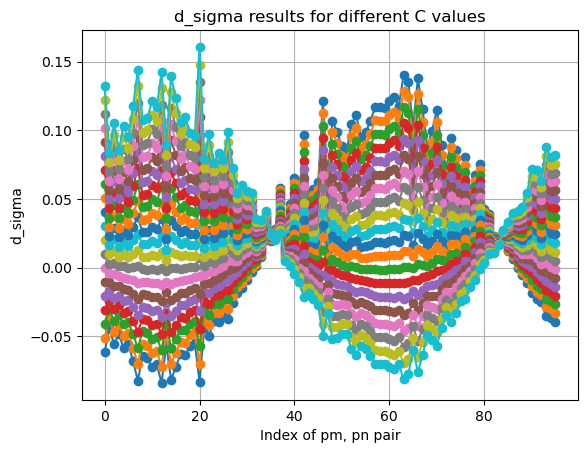

In [12]:
# Plotting each d_sigma result for each C_value
for i, C in enumerate(C_values):
    plt.plot(range(len(d_sigma_results[i])), d_sigma_results[i], marker='o', label=f'C = {C}')

plt.xlabel('Index of pm, pn pair')
plt.ylabel('d_sigma')
plt.title('d_sigma results for different C values')
plt.grid(True)
plt.show()

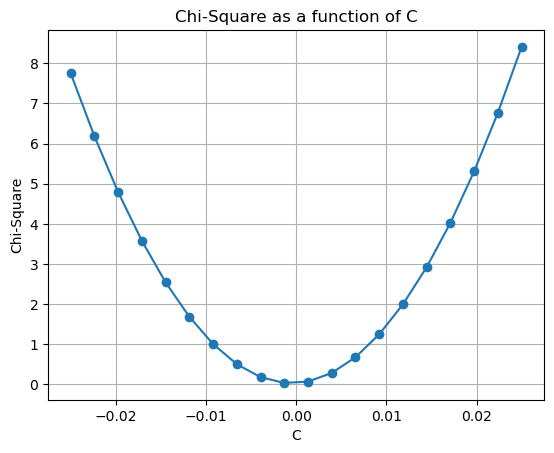

In [14]:
chi2_values = []
for results in d_sigma_results:
    chi2 = np.sum([(obs - res)**2 / obs for obs, res in zip(pseudo_data, results) if obs != 0])
    chi2_values.append(chi2)

# Plotting the chi-square as a function of C
plt.plot(linear_values, chi2_values, marker='o')
plt.xlabel('C')
plt.ylabel('Chi-Square')
plt.title('Chi-Square as a function of C')

ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.show()
